###Optimization - SGD

In [1]:
import torch

In [2]:
torch.FloatTensor(range(5))

tensor([0., 1., 2., 3., 4.])

In [3]:
torch.FloatTensor(range(5)).unsqueeze(1)

tensor([[0.],
        [1.],
        [2.],
        [3.],
        [4.]])

In [4]:
x = torch.FloatTensor(range(5)).unsqueeze(1)
y = 2*x + torch.rand(5, 1)
num_features = x.shape[1]

In [5]:
w = torch.randn(num_features, 1, requires_grad=True)
b = torch.randn(1, requires_grad=True)
optimizer = torch.optim.SGD([w, b], lr=1e-3)

loss_stack = []
for epoch in range(1000) :
  optimizer.zero_grad()
  a = torch.matmul(x, w) + b
  loss = torch.mean((a-y)**2)
  loss.backward()
  optimizer.step()
  #item() - Tensor에서 값만 가져옴
  loss_stack.append(loss.item())

###Custom Dataset

In [71]:
from torch.utils.data import DataLoader, Dataset

import torchvision
# 이미지 전처리 라이브러리 
import torchvision.transforms as tr
import numpy as np
import matplotlib.pyplot as plt

In [122]:
class ToTensor:
  # __call__ 함수 : 클래스의 인스턴스가 호출됐을 때 사용됨 
  # ex ) a = ToTensor()  
  # a(dataset) => call 함수 실행 

  def __call__(self, sample) :
    inputs, labels = sample
    inputs = torch.FloatTensor(inputs)
    inputs = inputs.permute(2, 0, 1)
    return inputs, torch.LongTensor(labels)

In [84]:
class CustomDataset(Dataset) :
  def __init__(self, x_data, y_data, transform=None):
    self.x_data = x_data
    self.y_data = y_data
    self.transform = transform
    self.len = len(y_data)
    self.tensor = ToTensor()

  
  def __getitem__(self, index) :
    sample = self.x_data[index], self.y_data[index]

    if self.transform : 
      sample = self.transform(sample)
    else :
      sample = self.transform(sample)
    return sample


  def __len__(self) :
    return self.len

In [125]:
class CutOut:
  # ratio 는 cut out 를 발생시킬 '0'이 나올 확률
  def __init__(self, ratio=.5) :
    self.ratio = int(1/ratio)
  
  def __call__(self, sample) :
    inputs, labels = sample
    # randint(low, high=None, size)
    active = int(np.random.randint(0, self.ratio, 1))

    # 0 일때 이미지를 cut out
    if active == 0 :
      c, w, h = inputs.size()
      min_len = min(w, h)
      # 최소 길이값을 이용해 적절한 box 크기 설정
      box_size = int(min_len//4)
      # 랜덤으로 box 자리 선택후 0 으로 대체 
      idx = int(np.random.randint(0, min_len-box_size, 1))
      inputs[:, idx:idx+box_size, idx:idx+box_size] = 0

    return inputs, labels

In [102]:
def imshow(img) :
  plt.figure(figsize=(10, 100))
  plt.imshow(img.permute(1, 2, 0).numpy())

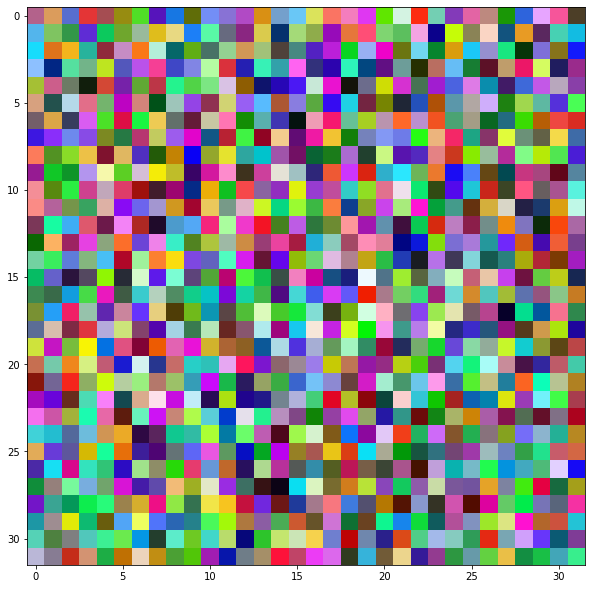

In [126]:
train_x = np.random.randint(256, size=(100, 32, 32, 3))/255
train_y = np.random.randint(2, size=(100, 1))

# Compose 를 사용하면 여러 데이터 전처리 기법을 한번에 묶을 수 있다.
trans = tr.Compose([ToTensor(), CutOut()])
dataset = CustomDataset(train_x, train_y, transform=trans)

train_loader = DataLoader(dataset, batch_size=10, shuffle=True)
# DataLoader 클래스는 data 들을 Dataset 오브젝트를 구성
images, labels = iter(train_loader).next()
imshow(images[0])
# imshow(torchvision.utils.make_grid(images, nrow=10))

### PIL 이미지의 Transform & Cut out

In [118]:
class PilTransform :
  def __call__(self, sample) :
    inputs, labels = sample
    inputs = torch.FloatTensor(inputs)
    inputs = inputs.permute(2, 0, 1)
    lables = torch.FloatTensor(labels)

    transf = tr.Compose([tr.ToPILImage(), tr.Resize(128), tr.ToTensor()])
    final_output = transf(inputs)

    return final_output, labels

In [112]:
class PilCutOut:
  def __init__(self, ratio=.5) :
    self.ratio = int(1/ratio)
  
  def __call__(self, sample) :
    # 위에서 만들었던 Custom Dataset 과 다르게, label 값을 함께 처리하지않고 이미지만 받아서 처리하는 형식으로 
    # 설계되어있기 때문에 이미지와 라벨을 모두 받지 않고 이미지만 받아 처리한다.
    active = int(np.random.randint(0, self.ratio, 1))
    if active == 0 :
      _, w, h = sample.size()
      min_len = min(w, h)
      box_size = int(min_len//4)
      idx = int(np.random.randint(0, min_len-box_size, 1))
      sample[:, idx:idx+box_size, idx:idx+box_size] = 0

    return sample

In [119]:
# PIL Image 타입에 맞도록 전처리
transf = tr.Compose([tr.Resize(128), tr.ToTensor(), PilCutOut()])
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transf)

Files already downloaded and verified


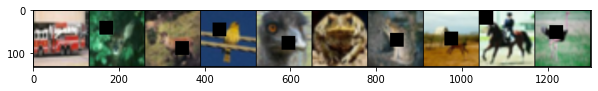

In [121]:
train_loader2 = DataLoader(train_set, batch_size=10, shuffle=True)
images, labels = iter(train_loader2).next()
imshow(torchvision.utils.make_grid(images, nrow=10))